In [47]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 2.3 MB/s eta 0:00:00


# Initializing TPU

In [1]:
import tensorflow as tf

try:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

    # instantiate a distribution strategy
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
except:
    print('No TPU present.')
    tpu_strategy = strategy = tf.distribute.get_strategy()

# Wine Quality Analysis using Physicochemical Properties


## Dataset Description
The dataset contains physicochemical properties and sensory quality scores of Portuguese "Vinho Verde" wine, combining both red and white variants. It includes 11 input variables: fixed acidity (g/dm³), volatile acidity (g/dm³), citric acid (g/dm³), residual sugar (g/dm³), chlorides (g/dm³), free sulfur dioxide (mg/dm³), total sulfur dioxide (mg/dm³), density (g/cm³), pH, sulphates (g/dm³), and alcohol (% by volume). The output variable is quality, scored between 0 and 10 based on sensory data. The dataset can be used for classification or regression tasks, with the goal of predicting wine quality based on its physicochemical properties. 🍷

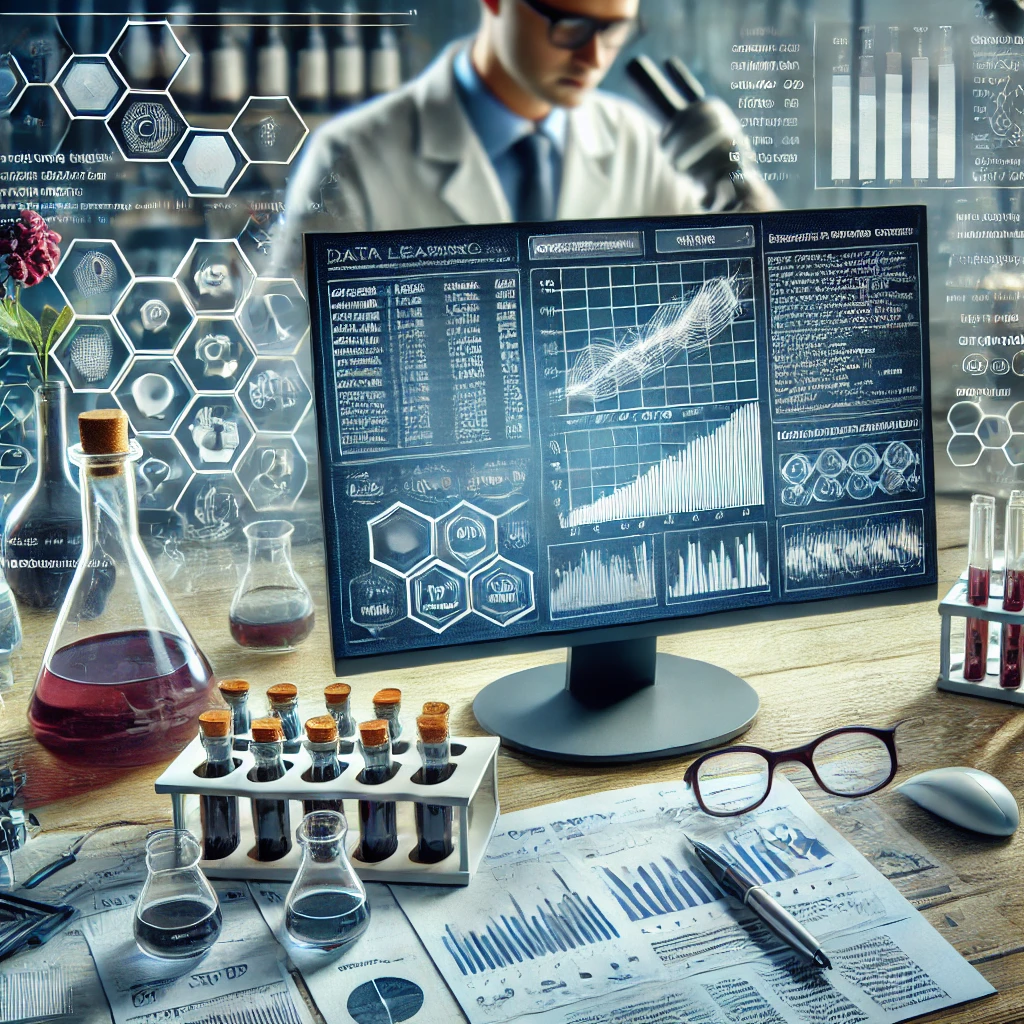                                        

Dataset Link - [Wine Quality](https://www.kaggle.com/datasets/rajyellow46/wine-quality)

## Importing Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Dataset

In [24]:
df = pd.read_csv('wine-quality.csv')
df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## Dataset Overview and Initial Inspection

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


### Data Types and Missing Values

So, only 'type' is Categorical type, rest are all numerical columns.

### Descriptive Statistics

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6487.0,7.216579,1.296750,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6489.0,0.339691,0.164649,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6494.0,0.318722,0.145265,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6495.0,5.444326,4.758125,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6495.0,0.056042,0.035036,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6488.0,3.218395,0.160748,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6493.0,0.531215,0.148814,0.22000,0.43000,0.51000,0.60000,2.00000


### Checking for Missing Values

In [27]:
df.isnull().sum()

,0
type,0
fixed acidity,10
volatile acidity,8
citric acid,3
residual sugar,2
chlorides,2
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,9


### Exploring Categorical Variables

In [28]:
df['type'].unique()

array(['white', 'red'], dtype=object)

### Handling Missing Values

In [29]:
for col in df.columns:
  if df[col].isnull().sum() > 0:
    df[col] = df[col].fillna(df[col].mean())

## Data Visualization

### Distribution of Features

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

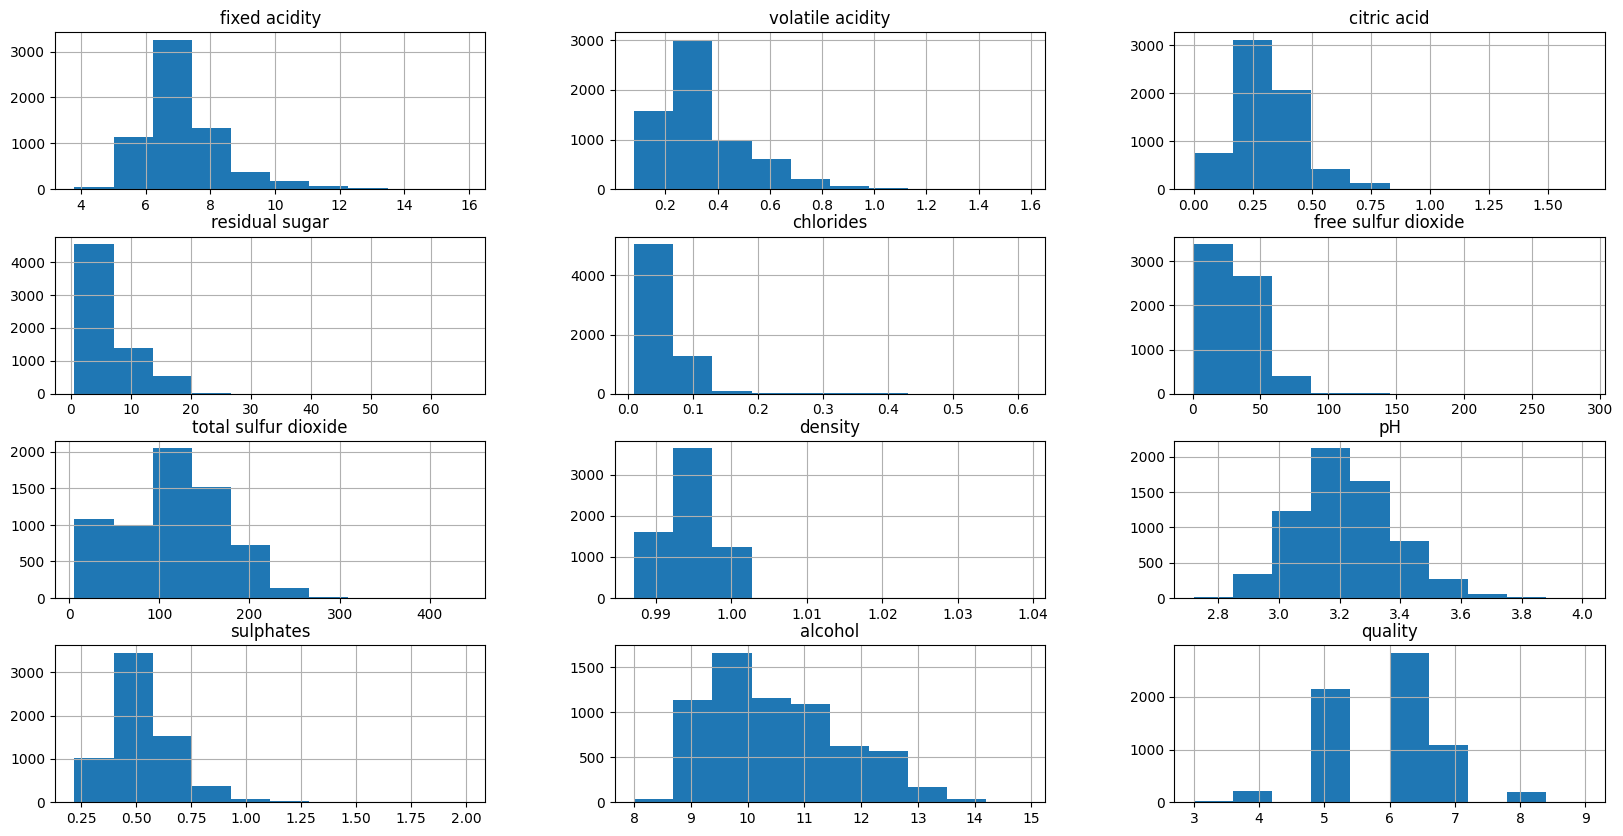

In [30]:
df.hist(figsize=(20, 10))

### Pairplot of Selected Features

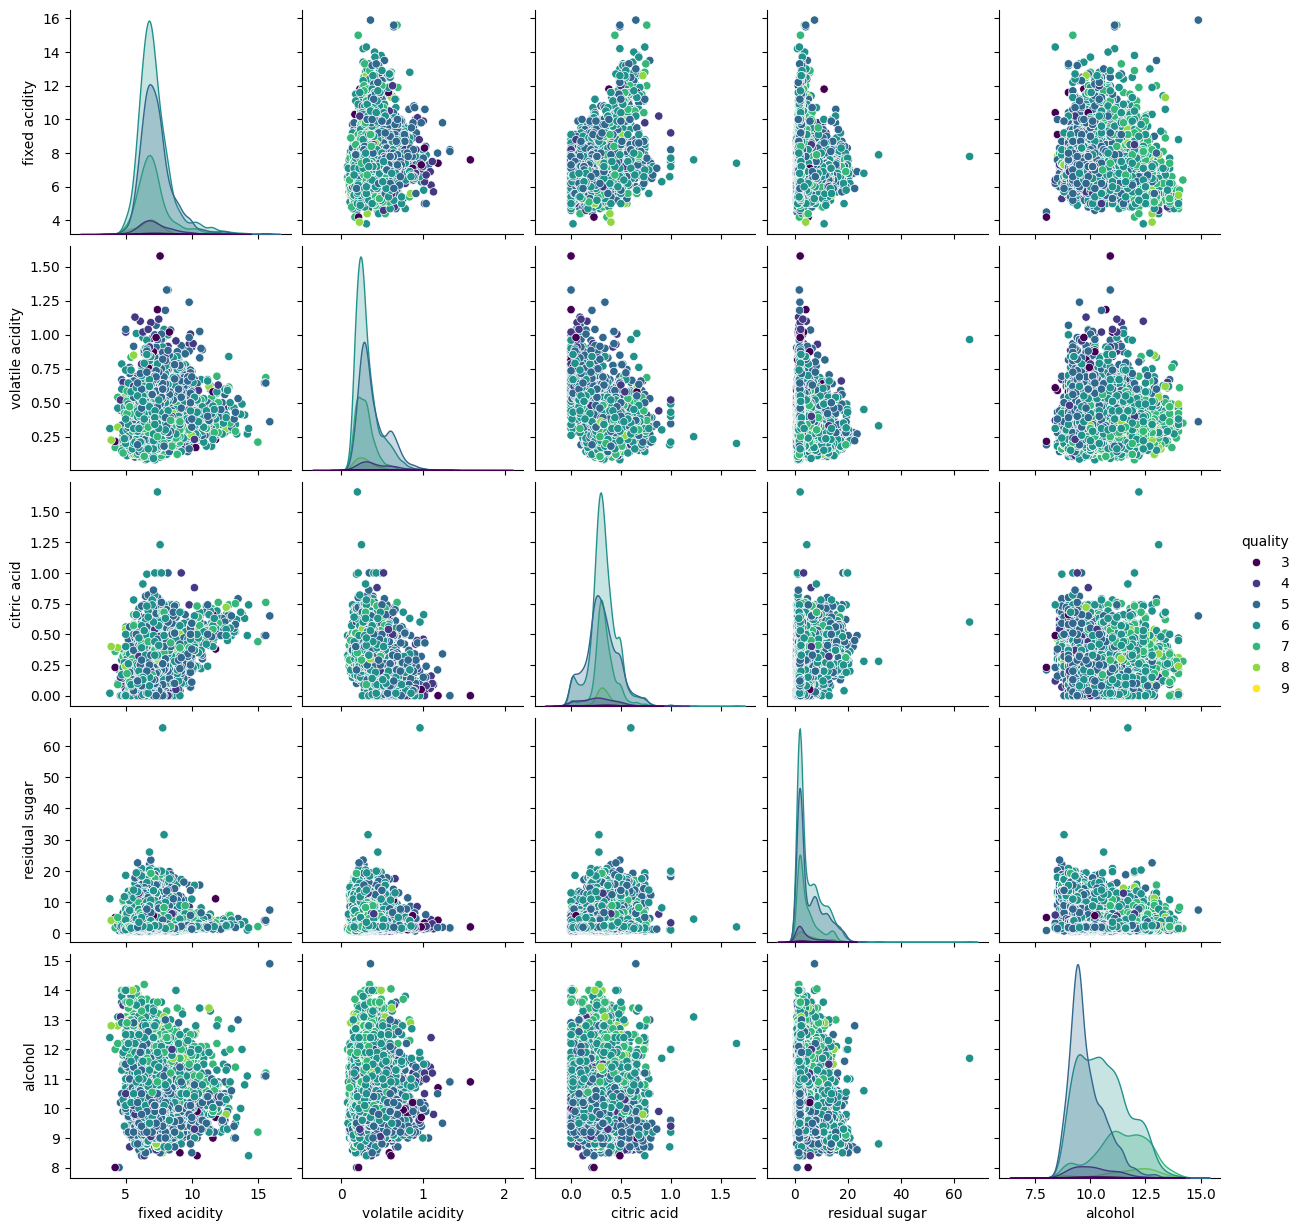

In [31]:
sns.pairplot(df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'alcohol', 'quality']], hue='quality', palette='viridis')
plt.show()

<Axes: >

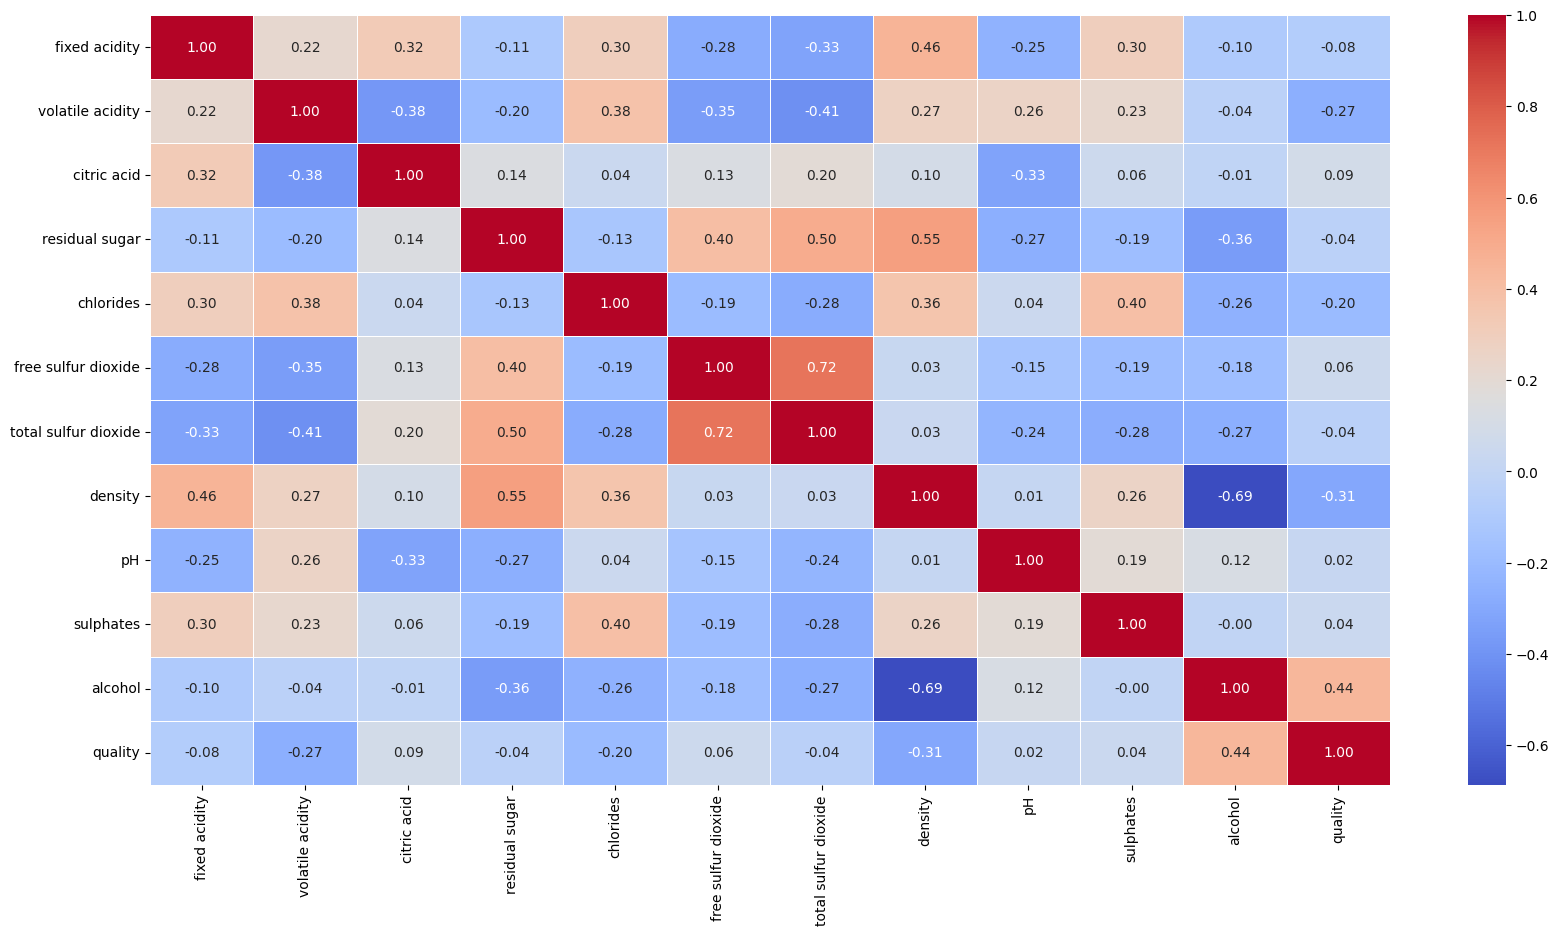

In [32]:
# Select only the numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

# Compute the correlation matrix
corr = df[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

In [33]:
df.quality.unique()

array([6, 5, 7, 8, 4, 3, 9])

In [34]:
df_dummies = pd.get_dummies(df, columns=['type'])
df_dummies

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.450000,8.8,6,False,True
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.490000,9.5,6,False,True
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.440000,10.1,6,False,True
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,6,False,True
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,6,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.580000,10.5,5,True,False
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.531215,11.2,6,True,False
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.750000,11.0,6,True,False
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.710000,10.2,5,True,False


## Approach 1: Binary Classification

### Using Artificial Neural Network (ANN)

In [35]:
df_dummies['best quality'] = [1 if x > 5 else 0 for x in df_dummies['quality']]

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df = df_dummies.copy()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

X = df.drop(columns=['best quality', 'quality'])
y = df['best quality']

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

X_train = tf.cast(X_train , dtype=tf.float32)
y_train = tf.cast(y_train , dtype=tf.float32)

with tpu_strategy.scope():
  model = Sequential()
  model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
  callbacks = [early_stopping_callback, reduce_lr]

  history = model.fit(X_train, y_train, epochs=25, batch_size=128, validation_split=0.2, callbacks=callbacks)

Epoch 1/25
33/33 [==============================] - 5s 78ms/step - loss: 0.6577 - accuracy: 0.6271 - val_loss: 0.6363 - val_accuracy: 0.6452 - lr: 0.0010
Epoch 2/25
33/33 [==============================] - 1s 28ms/step - loss: 0.6434 - accuracy: 0.6339 - val_loss: 0.6240 - val_accuracy: 0.6452 - lr: 0.0010
Epoch 3/25
33/33 [==============================] - 1s 28ms/step - loss: 0.6317 - accuracy: 0.6476 - val_loss: 0.6124 - val_accuracy: 0.6567 - lr: 0.0010
Epoch 4/25
33/33 [==============================] - 1s 28ms/step - loss: 0.6230 - accuracy: 0.6471 - val_loss: 0.6009 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 5/25
33/33 [==============================] - 1s 28ms/step - loss: 0.6084 - accuracy: 0.6550 - val_loss: 0.5902 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 6/25
33/33 [==============================] - 1s 28ms/step - loss: 0.5993 - accuracy: 0.6673 - val_loss: 0.5789 - val_accuracy: 0.7019 - lr: 0.0010
Epoch 7/25
33/33 [==============================] - 1s 28ms/step - loss: 0.5

### Accuracy & Loss Plots

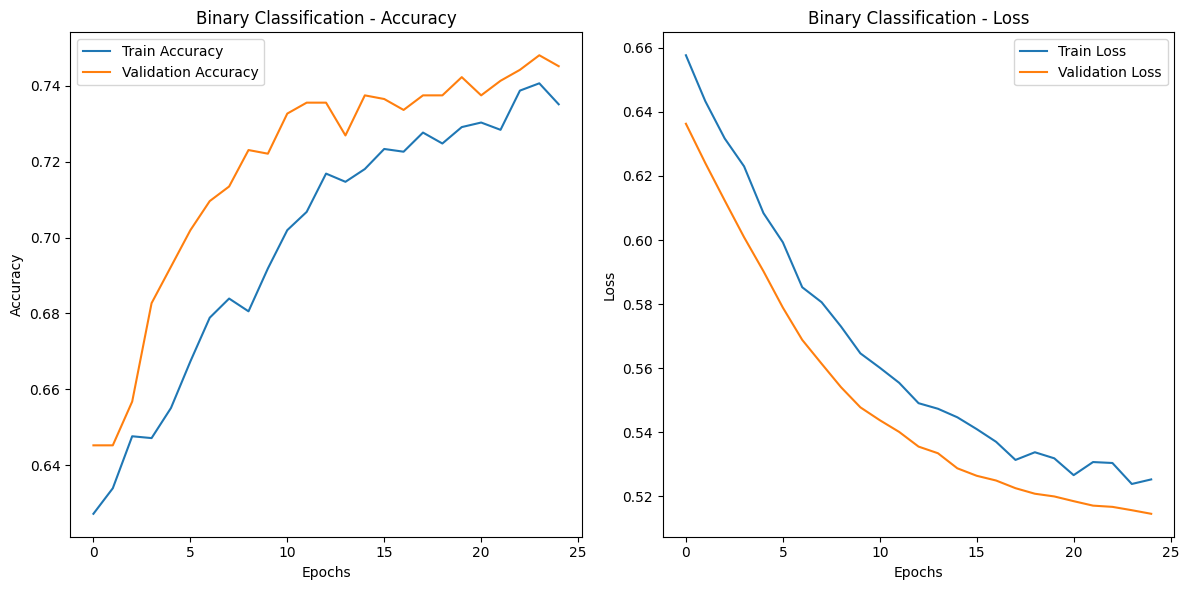

In [43]:
# Plotting Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Binary Classification - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Binary Classification - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import accuracy_score

X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")
nn_accuracy = accuracy_score(y_test, y_pred_nn)
print(f'ANN Accuracy: {nn_accuracy}')

41/41 [==============================] - 1s 10ms/step
ANN Accuracy: 0.7315384615384616


### Using Classifiers

In [49]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

with tpu_strategy.scope():
  models = {
      'SVC': SVC(),
      'Logistic Regression': LogisticRegression(),
      'XGBClassifier': XGBClassifier()
  }

  for name, model in models.items():
      model.fit(X_train, y_train)
      score = model.score(X_test, y_test)
      print(f'{name} Accuracy: {score}')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


SVC Accuracy: 0.74
Logistic Regression Accuracy: 0.7353846153846154


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


XGBClassifier Accuracy: 0.8146153846153846


### Cross-Validation

In [52]:
from sklearn.model_selection import cross_val_score

with tpu_strategy.scope():
  dtc_scores = cross_val_score(SVC(), X, y, cv=10, scoring='accuracy')
dtc_scores

array([0.70461538, 0.73538462, 0.76615385, 0.71076923, 0.73076923,
       0.73384615, 0.74769231, 0.81355932, 0.63328197, 0.75808937])

In [53]:
dtc_scores.mean()

0.7334161431788551

## Approach 2: Multi-Class Classification

### Using Artificial Neural Network (ANN)

In [54]:
df_dummies = df_dummies.drop(columns='best quality', errors='ignore')
num_classes = 11

In [55]:
scaler = MinMaxScaler()
df_scaled = df_dummies.copy()
df_scaled[df_scaled.columns[:-1]] = scaler.fit_transform(df_scaled[df_scaled.columns[:-1]])

X = df_scaled.drop(columns='quality')
y = df_scaled['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [58]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

with tpu_strategy.scope():
  model = Sequential()
  model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(X_train, y_train_cat, epochs=25, batch_size=128, validation_split=0.2)

Epoch 1/25
33/33 [==============================] - 5s 76ms/step - loss: 2.0515 - accuracy: 0.5247 - val_loss: 1.5576 - val_accuracy: 0.9990
Epoch 2/25
33/33 [==============================] - 1s 28ms/step - loss: 1.0905 - accuracy: 0.9978 - val_loss: 0.5460 - val_accuracy: 0.9990
Epoch 3/25
33/33 [==============================] - 1s 28ms/step - loss: 0.3125 - accuracy: 0.9993 - val_loss: 0.1165 - val_accuracy: 0.9990
Epoch 4/25
33/33 [==============================] - 1s 28ms/step - loss: 0.0944 - accuracy: 0.9993 - val_loss: 0.0463 - val_accuracy: 0.9990
Epoch 5/25
33/33 [==============================] - 1s 28ms/step - loss: 0.0492 - accuracy: 0.9993 - val_loss: 0.0278 - val_accuracy: 0.9990
Epoch 6/25
33/33 [==============================] - 1s 28ms/step - loss: 0.0329 - accuracy: 0.9993 - val_loss: 0.0204 - val_accuracy: 0.9990
Epoch 7/25
33/33 [==============================] - 1s 27ms/step - loss: 0.0258 - accuracy: 0.9993 - val_loss: 0.0166 - val_accuracy: 0.9990
Epoch 8/25
33

### Accuracy & Loss Plots

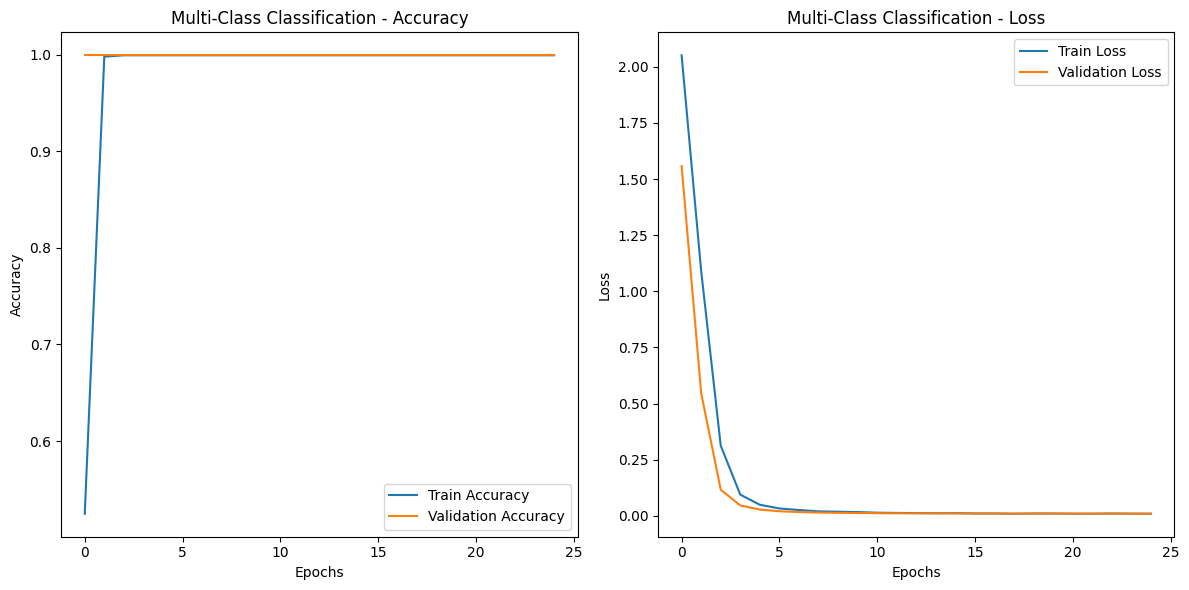

In [59]:
# Plotting Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multi-Class Classification - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Multi-Class Classification - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [61]:
X_test = X_test.astype('float32')

y_pred_nn = model.predict(X_test)
y_pred_nn = y_pred_nn.argmax(axis=1)
y_test_true = y_test_cat.argmax(axis=1)

nn_accuracy = accuracy_score(y_test_true, y_pred_nn)
print(f'ANN Accuracy: {nn_accuracy}')

41/41 [==============================] - 1s 10ms/step
ANN Accuracy: 0.9992307692307693


### Saving the Model

In [62]:
# Export the model architecture as a JSON file
with open('model.json', 'w') as json_file:
    json_file.write(model.to_json())

'''This file will open in Netron(online).'''

'This file will open in Netron(online).'

In [63]:
import joblib

joblib.dump(model, 'model.joblib')

['model.joblib']

### Using Classifiers

In [64]:
with tpu_strategy.scope():
  models = {
      'SVC': SVC(),
      'Logistic Regression': LogisticRegression(multi_class='multinomial'),
      'XGBClassifier': XGBClassifier(objective='multi:softmax', num_class=10)
  }

  for name, model in models.items():
      model.fit(X_train, y_train.astype(int))
      y_pred = model.predict(X_test)
      score = accuracy_score(y_test.astype(int), y_pred)
      print(f'{name} Accuracy: {score}')

SVC Accuracy: 0.9992307692307693
Logistic Regression Accuracy: 0.9992307692307693
XGBClassifier Accuracy: 0.9992307692307693
